# Script to generate routes between fed locations

Code derived from https://ipython-books.github.io/147-creating-a-route-planner-for-a-road-network/

Data(.shp file) from https://mapcruzin.com/free-delhi-country-city-place-gis-shapefiles.htm

In [1]:
import io
import os
import zipfile
import networkx as nx
import numpy as np
import pandas as pd
import json
import smopy
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'F:\\Valerio\\Scripts and Plots\\ValerioTrials\\Geocoding')

In [4]:
def unzip_file(name):
  zipped_file = name
  zip_ref = zipfile.ZipFile(zipped_file, 'r')
  zip_ref.extractall('.')
  zip_ref.close()

In [5]:
unzip_file('delhi_highway.zip')

In [6]:
import gdal
g = nx.read_shp('delhi_highway.shp')

In [7]:
# Requires a lot of space, graph too big

# nx.draw(g)
# plt.show()

In [8]:
# Graph might not be connected, this function will yield the largest connected subgraph.
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

sgs = list(connected_component_subgraphs(g.to_undirected())) # sgs is a list of subgraphs

i = np.argmax([len(sg) for sg in sgs]) # i holds the location of the largest connected subgraph
# print(i)
sg = sgs[i] # sg is the subgraph of interest

# print(len(sg)) # number of nodes in this subgraph

In [496]:
from GeocodeAddress import geocoding
print("Enter source: ")
address = input()
pos0 = geocoding(address)
print("Enter destination: ")
address = input()
pos1 = geocoding(address)

Enter source: 
Delhi Cantt Railway Station, Delhi, India
Enter destination: 
Indira Gandhi International Airport, Delhi, India


In [497]:
print("Source entered: ", pos0)
print("Destination entered: ", pos1)

Source entered:  (28.583535599999998, 77.12598539099099)
Destination entered:  (28.55489735, 77.08467458266915)


In [498]:
def get_path(n0, n1): # n0 and n1 are tuples(containing the latitude and longitude) of the 2 locations
# returns points linking the 2 given locations
    return np.array(json.loads(sg[n0][n1]['Json'])
                    ['coordinates'])

In [499]:
radius = 6372.8
def calcDist(lat0, lon0, lat1, lon1):
    # calculates and returns the Great-Circle Distance using the cosine formula****(in km)****
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    dlon = lon0 - lon1
    
    y = np.sqrt((np.cos(lat1) * np.sin(dlon)) ** 2 +
        (np.cos(lat0) * np.sin(lat1) - np.sin(lat0) *
         np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    
    return radius*c

In [500]:
# leverages the calcDist function to calculate the length between given 2 points
def get_path_length(path):
    return np.sum(calcDist(path[1:, 1], path[1:, 0], path[:-1, 1], path[:-1, 0])) # pass the lat and lon of the 2 points

Get Charging Stations from csv

In [501]:
df = pd.read_csv('ModifiedStations.csv')
df['location'] = list(zip(df.LATITUDE, df.LONGITUDE))

In [502]:
stations = []
for station in df.location:
    stations.append(station)
    
stations = np.array(stations) # Convert list to numpy array
    
stations = stations[:, ::-1]  # Flip the tuple from (lat, lon) to (lon, lat)
# print(stations)

station_set = set()
for val in stations:
    val = val.tolist()
    val = tuple(val)
    station_set.add(val)
    
# print(station_set)  # Set of locations of the charging stations stored as tuples.(lon, lat)

In [503]:
# Get charging station closest to the source
distToStation = 1e10
# Store the location of the station closest to the source
closestStation = []

# pos0 is the user-entered source
for val in stations:
    dist = calcDist(val[1], val[0], pos0[0], pos0[1])      # User entered values are (lat, lon) all others are (lon, lat)
    if dist < distToStation:
        closestStation = val
        distToStation = dist
        
print("Charging Station closest to source point entered: ", closestStation)
print("Distance of the closest charging station from source(in km): ", distToStation)

Charging Station closest to source point entered:  [77.18345  28.578729]
Distance of the closest charging station from source(in km):  5.638108406187961


In [504]:
maxDistance = None  # Max distance car can travel on current charge. To be incorporated later.
tolerance = 0.3    # How far away can a charging station be from this route(in kilometers)

def isPresent(possible, val):
    check = tuple(val)
    for loc in station_set:
        dist = calcDist(check[1], check[0], loc[1], loc[0])
        if dist <= tolerance and loc not in possible:
            possible.append(loc)
        
    return possible

Build graph

In [505]:
# Update the graph edges by assigning them actual distance

possible = [] # possible charging stations all of which lie on the route.

for n0, n1 in sg.edges:
    path = get_path(n0, n1) # will return numpy array of points, path is a list of lats and lons each returned in a list format, hence a list of lists.
    
    # Add a check to see if returned array of points has any charging stations....
    for val in path:
        possible = isPresent(possible, val)
    
    # print(path)
    # print("End of a segment")
    
    dist = get_path_length(path)
    sg.edges[n0, n1]['distance'] = dist # update step
    


# print(possible)

# possible is non-empty for atleast 300m tolerance value, i.e., there is no point in our list of 'nodes' that is closer
# to a charging station than 300m.

In [506]:
# Our requested positions might not be on the graph, find the locations on the graph closest to them

# print(sg.edges)   # Returns list of nested tuples.
# print(sg.nodes)   # Returns list of nodes.
# print(len(sg))    # Number of nodes in this subgraph.

# get all the nodes of the constructed graph into an array and find the point closest to target point.
nodes = np.array(sg.nodes)
# print("Nodes array: ", nodes) # returns list of latitudes and longitudes(Total 278 datapoints)(latitudes and longitudes are stored as list and not tuple)
#  Nodes are also stored as (lon, lat).

In [507]:
def getClosestPointIndex(loc):
    loc_i = np.argmin(np.sum((nodes[:, ::-1] - loc)**2, axis=1))
    return loc_i

In [508]:
# Get the closest nodes in the graph. source_i and destination_i return index of the points closest to requested points in the nodes array
source_i = getClosestPointIndex(pos0)
destination_i = getClosestPointIndex(pos1)
# Get the point closest to the charging station.
station_i = np.argmin(np.sum((nodes - closestStation)**2, axis=1))


print("Source, Closest charging station and Destination indices: ", source_i, station_i, destination_i)

Source, Closest charging station and Destination indices:  268 160 139


Instantiate the map 

In [509]:
m = smopy.Map(pos0, pos1, z=7, margin=.1)

In [510]:
def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    for i in range(len(path) - 1):
        p = get_path(path[i], path[i + 1])
        if curp is None:
            curp = p
        if (np.sum((p[0] - curp) ** 2) >
                np.sum((p[-1] - curp) ** 2)):
            p = p[::-1, :]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

In [511]:
# Compute the shortest path from source to nearest charging station.
path1 = nx.shortest_path(
    sg,
    source=tuple(nodes[source_i]),
    target=tuple(nodes[station_i]),
    weight='distance')  # Computes the shortest path (weighted by distance).

# Compute the shortest path from charging station to destination.
path2 = nx.shortest_path(
    sg,
    source=tuple(nodes[station_i]),
    target=tuple(nodes[destination_i]),
    weight='distance')

# path = path1+path2 # is the final path from source->nearest charging station->destination
# print("Path 1: ", path1)
# print("Path 2: ", path2)
# print("Path: ", path)
# The path variable now contains the list of edges that form the shortest path between requested positions
# print(len(path))

In [512]:
# Get the co-ordinates of the approximate source, charging station and destination:
print("Source: ", nodes[source_i])
print("Station: ", nodes[station_i])
print("Destination: ", nodes[destination_i])

Source:  [77.1364627 28.6163999]
Station:  [77.177488  28.5762264]
Destination:  [77.0800163 28.6304438]


In [513]:
if source_i != station_i:
    linepath = get_full_path(path1)
    print(linepath)
    a, b = m.to_pixels(linepath[:, 1], linepath[:, 0])
    
else:
    print("There's a charging station right where you are !")
    
# # print(len(a))
# # print(len(b))

[[77.1364627 28.6163999]
 [77.1363846 28.61803  ]
 [77.1364214 28.6197164]
 [77.1364627 28.6203081]
 [77.1364306 28.6205858]
 [77.1363326 28.6209005]
 [77.1352868 28.6236492]
 [77.1337819 28.6275058]
 [77.1337819 28.6275058]
 [77.1335876 28.6280039]
 [77.132341  28.6311984]
 [77.132341  28.6311984]
 [77.1321582 28.631667 ]
 [77.1321582 28.631667 ]
 [77.1318968 28.6323768]
 [77.1317449 28.632789 ]
 [77.1313042 28.6339857]
 [77.1313042 28.6339857]
 [77.1307964 28.6353646]
 [77.1299452 28.6376169]
 [77.1291449 28.639713 ]
 [77.1291449 28.639713 ]
 [77.1286451 28.6409902]
 [77.1263494 28.6468583]
 [77.1263276 28.6469207]
 [77.1261959 28.6472818]
 [77.1258548 28.6482187]
 [77.1256375 28.6487608]
 [77.1256375 28.6487608]
 [77.1254531 28.6492209]
 [77.1247379 28.6507695]
 [77.1246668 28.650923 ]
 [77.1243284 28.6516381]
 [77.1241734 28.6521114]
 [77.1240931 28.6525093]
 [77.1241046 28.6528315]
 [77.1241505 28.6532193]
 [77.1242308 28.6535114]
 [77.1243284 28.6537934]
 [77.1244947 28.6540502]


In [514]:
linepath = get_full_path(path2)
print(linepath)
x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])

[[77.1875824 28.5698265]
 [77.1862964 28.569974 ]
 [77.1850348 28.570113 ]
 [77.184085  28.5702176]
 [77.1835634 28.5703578]
 [77.1829375 28.5706378]
 [77.1826074 28.5707855]
 [77.1816895 28.5712735]
 [77.180318  28.5722038]
 [77.1798546 28.5726295]
 [77.1790158 28.5737655]
 [77.1778323 28.575633 ]
 [77.177488  28.5762264]
 [77.1875824 28.5698265]
 [77.189387  28.5696228]
 [77.1911331 28.5694443]
 [77.1919236 28.5693878]
 [77.1919236 28.5693878]
 [77.1931859 28.5693841]
 [77.193928  28.5694227]
 [77.1964242 28.5696359]
 [77.1973372 28.569711 ]
 [77.1973372 28.569711 ]
 [77.1993426 28.569876 ]
 [77.2002414 28.5699034]
 [77.200798  28.5698931]
 [77.2013359 28.5698471]
 [77.2021033 28.5697803]
 [77.2021033 28.5697803]
 [77.2027278 28.5697613]
 [77.2044204 28.5696818]
 [77.2060804 28.5695941]
 [77.2063729 28.5696321]
 [77.2067053 28.5697319]
 [77.207008  28.5699288]
 [77.207553  28.5702888]
 [77.2081469 28.5706551]
 [77.2084716 28.5707595]
 [77.2084716 28.5707595]
 [77.2087722 28.5707815]


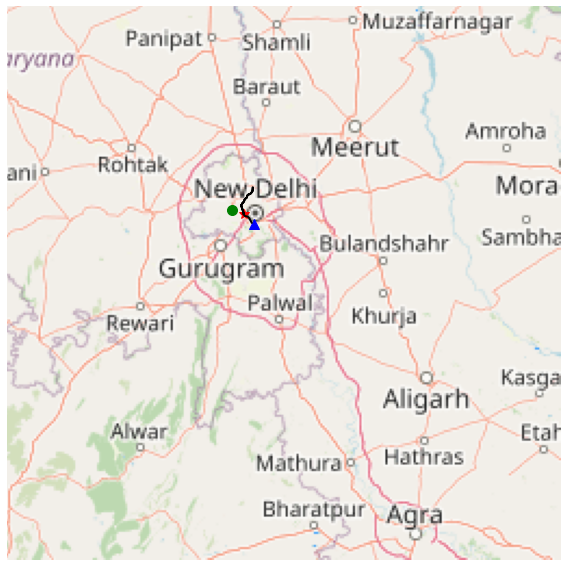

In [516]:
ax = m.show_mpl(figsize=(8, 8))

# Mark our positions.(Source->Station->Destination : RBG)
if source_i != station_i:
    ax.plot(a[0], b[0], 'or', ms=10, marker='*')  # Source is marked with a star * in red.

# ax.plot(a[-1], b[-1], 'oy', ms=10)
ax.plot(x[0], y[0], 'ob', ms=10, marker='^')  # Charging station is marked with a ^ in blue.
ax.plot(x[-1], y[-1], 'og', ms=10)            # Destination is marked with a . in green.

# Mark the 2 paths, first from source to closest charging station and then from there on to the destination.
if source_i != station_i:
    ax.plot(a, b, '-k', lw=2) # Source to station is marked with black.

ax.plot(x, y, '-y', lw=2) # Station to destination is marked with yellow.

# NOTE: If the black and yellow lines overlap, yellow will be seen.